In [ ]:
import os
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
def read_parquet_by_type(train_path: str):
    # Lấy tất cả các file parquet trong thư mục
    files = [os.path.join(train_path, f) for f in os.listdir(train_path) if f.endswith('.parquet')]
    
    # Phân loại các file theo loại tên
    user_chunk_files = [file for file in files if 'user_chunk' in file]
    purchase_history_chunk_files = [file for file in files if 'purchase_history_daily_chunk' in file]
    item_chunk_files = [file for file in files if 'item_chunk' in file]
    
    # Đọc các file riêng biệt thành DataFrame
    user_chunk_df = pl.concat([pl.read_parquet(file) for file in user_chunk_files]) if user_chunk_files else None
    purchase_history_chunk_df = pl.concat([pl.read_parquet(file) for file in purchase_history_chunk_files]) if purchase_history_chunk_files else None
    item_chunk_df = pl.concat([pl.read_parquet(file) for file in item_chunk_files]) if item_chunk_files else None
    
    # Trả về một dictionary chứa các DataFrame
    return {
        "user_chunk": user_chunk_df,
        "purchase_history_chunk": purchase_history_chunk_df,
        "item_chunk": item_chunk_df
    }

In [ ]:
train_path = 'E:/KHMT2023_CS_UIT/05_C_Python_For_ML/recommendation_dataset'
dataframes = read_parquet_by_type(train_path)

In [ ]:


df_user = dataframes["user_chunk"]
df_purchase = dataframes["purchase_history_chunk"]
df_item = dataframes["item_chunk"]

# User chunk

## Loại bỏ cột

| Cột              | Giữ / Loại bỏ       | Lý do                                                                                                               |
| ---------------- | ------------------- | ------------------------------------------------------------------------------------------------------------------- |
| `customer_id`, `user_id`    | ✅ Giữ| các biến định danh, không mang ý nghĩa thống kê trong phân tích dữ liệu. Nhưng  có thể giữ lại để liên kết với purchase chunk và item chunk|
| `gender`         | ✅ Giữ               | Có thể ảnh hưởng đến hành vi mua hàng                                                                               |
| `location`       | ✅ Giữ               | Thể hiện mã khu vực – hữu ích trong phân tích địa lý                                                                |
| `province`       | ✅ Giữ               | Dùng phân tích xu hướng theo địa phương                                                                             |
| `region`         | ✅ Giữ               | Cung cấp thông tin phân cấp cao hơn, có thể hữu ích trong mô hình                                                   |
| `membership`     | ✅ Giữ               | Ảnh hưởng lớn đến hành vi và giá trị khách hàng                                                                     |
| `sync_status_id` | ❌ Loại bỏ           | Gần như toàn bộ giá trị Null, phần còn lại đều bằng 2 → không có giá trị phân biệt                                  |
| `location_name`  | ❌ Loại bỏ           | Dữ liệu quá chi tiết, rời rạc và không khái quát được                                                               |
| `install_app`    | ✅ Giữ               | Kênh cài đặt có thể ảnh hưởng đến tần suất mua hàng                                                                 |
| `district`       | ⚙️ Giữ có điều kiện | Có thể giữ nếu cần phân tích chi tiết theo khu vực; nếu không, loại bỏ do trùng lặp thông tin địa lý với `province` |
| `is_deleted`     | ❌ Loại bỏ           | Toàn bộ là `False`, không mang thông tin                                                                            |


## Xử lý NULL và Outlier

| Cột              | Giữ / Loại bỏ       | Lý do                                                                                                               |
| ---------------- | ------------------- | ------------------------------------------------------------------------------------------------------------------- |
| `customer_id`, `user_id`    | ✅ Giữ| Không có Null và Outlier|
| `gender`         | ✅ Giữ               | Không có Null và Outlier|
| `location`       | ✅ Giữ               | Không có Null và Outlier|
| `province`       | ⚙️ Xử lý               | Cần xử lý tên tỉnh và thành phố do chưa thống nhất cách đặt tên |
| `region`         | ✅ Giữ               | Không có Null và Outlier|
| `membership`     | ✅ Giữ               | Không có Null và Outlier   |
| `install_app`    | ✅ Giữ               | Không có Null và Outlier |

## Xử lý Outlier

In [4]:
# Thay thế các giá trị "Thành Phố" và "Tỉnh" trong cột 'province'
df_user = df_user.with_columns(
    pl.col('province')
    .str.replace('Thành Phố ', '')  # Loại bỏ "Thành Phố"
    .str.replace('Tỉnh ', '')  # Loại bỏ "Tỉnh"
    .alias('province')  # Đặt lại tên cột sau khi thay thế
)

# In các giá trị duy nhất sau khi thay thế
unique_provinces = df_user['province'].unique().to_list()
print("Unique values in column 'province' after replacement:")
print(unique_provinces)

Unique values in column 'province' after replacement:
['Phú Yên', 'Thừa Thiên Huế', 'Cần Thơ', 'An Giang', 'Hải Dương', 'Hòa Bình', 'Quảng Trị', 'Bình Thuận', 'Thanh Hóa', 'Hà Tĩnh', 'Bình Định', 'Phú Thọ', 'Gia Lai', 'Cao Bằng', 'Vĩnh Phúc', 'Bình Phước', 'Sóc Trăng', 'Vĩnh Long', 'Hà Nội', 'Lai Châu', 'Thái Bình', 'Đồng Nai', 'Hải Phòng', 'Ninh Bình', 'Trà Vinh', 'Bắc Kạn', 'Ninh Thuận', 'Thái Nguyên', 'Khánh Hòa', 'Kiên Giang', 'Đà Nẵng', 'Hậu Giang', 'Bạc Liêu', 'Tiền Giang', 'Hà Nam', 'Bắc Ninh', 'Quảng Nam', 'Đắk Nông', 'Quảng Ninh', 'Bến Tre', 'Cà Mau', 'Điện Biên', 'Long An', 'Lạng Sơn', 'Nam Định', 'Quảng Bình', 'Hưng Yên', 'Hồ Chí Minh', 'Kon Tum', 'Lào Cai', 'Nghệ An', 'Yên Bái', 'Bắc Giang', 'Quảng Ngãi', 'Đồng Tháp', 'Lâm Đồng', 'Bà Rịa - Vũng Tàu', 'Bình Dương', 'Đắk Lắk', 'Sơn La', 'Hà Giang', 'Tây Ninh', 'Tuyên Quang']


# Purchase chunk

## Loại bỏ cột


| Cột            | Giữ / Loại bỏ | Lý do                                                                                                                                             |
| -------------- | ------------- | ------------------------------------------------------------------------------------------------------------------------------------------------- |
| `timestamp`    | ✅ Giữ         | Biểu diễn thời gian giao dịch, có thể phân tích xu hướng theo thời gian; cần chuyển từ UNIX timestamp sang dạng datetime để thuận tiện phân tích. |
| `user_id`      | ✅ Giữ         | Biến định danh người dùng, cần để liên kết với bảng `User Chunk`; không có ý nghĩa thống kê độc lập nhưng quan trọng cho join dữ liệu.            |
| `item_id`      | ✅ Giữ         | Dùng để xác định sản phẩm và phân tích tần suất, mức độ phổ biến của mặt hàng.                                                                    |
| `event_type`   | ❌ Loại bỏ     | Toàn bộ dữ liệu chỉ có giá trị “Purchase” → không mang thông tin phân biệt.                                                                       |
| `event_value`  | ❌ Loại bỏ     | Tương quan hoàn hảo với `quantity` (r = 1.0) → gây multicollinearity, nên giữ `quantity`.                                                         |
| `price`        | ✅ Giữ         | Biến quan trọng để phân tích doanh thu, hành vi giá và khuyến mãi; cần xử lý outlier (trimming hoặc winsorizing).                                 |
| `quantity`     | ✅ Giữ         | Thể hiện số lượng mua; cần xử lý outlier (giá trị quá lớn có thể là đơn hàng sỉ hoặc lỗi).                                                        |
| `date_key`     | ❌ Loại bỏ     | Tương quan gần tuyệt đối với `timestamp` (r ≈ 0.998) → dư thừa thông tin thời gian.                                                               |
| `customer_id`  | ✅ Giữ         | Biến định danh khách hàng, cần để liên kết với bảng `User Chunk`.                                                                                 |
| `created_date` | ✅ Giữ         | Thời điểm tạo đơn hàng, có thể khác thời điểm mua (timestamp); hữu ích trong phân tích hành vi và vận hành.                                       |
| `payment`      | ✅ Giữ         | Thông tin phương thức thanh toán (cash, transfer, v.v.) → quan trọng trong phân tích kênh thanh toán và hành vi người dùng.                       |
| `location`     | ✅ Giữ         | Cho phép phân tích xu hướng mua hàng theo khu vực; không có outlier.                                                                              |
| `discount`     | ✅ Giữ         | Thể hiện mức chiết khấu; cần chuẩn hóa hoặc winsorize do phân bố lệch và nhiều outlier.                                                           |
| `channel`      | ✅ Giữ         | Phân biệt kênh bán hàng (In-Store, Chat, CRM, v.v.), có mối liên hệ mạnh với `payment` → hữu ích trong phân tích hành vi.                         |
| `is_deleted`   | ❌ Loại bỏ     | Toàn bộ giá trị là `False` → không mang thông tin phân biệt.                                                                                      |


## Xử lý NULL Outlier


| Cột            | Giữ / Loại bỏ | Lý do                                                                                                                                             |
| -------------- | ------------- | ------------------------------------------------------------------------------------------------------------------------------------------------- |
| `timestamp`    | ✅ Giữ         | Không có NULL và Outlier |
| `user_id`      | ✅ Giữ         | Không có NULL và Outlier            |
| `item_id`      | ✅ Giữ         | Không có NULL và Outlier                                                   |
| `price`        | ⚙️ Xử lý         | Xử lý bằng winsorizing.                                 |
| `quantity`     | ⚙️ đặc trưng thống kê          | Thể hiện số lượng mua; cần xử lý outlier (giá trị quá lớn có thể là đơn hàng sỉ hoặc lỗi).                                                        |
| `customer_id`  | ✅ Giữ         | Không có NULL và Outlier  |
| `created_date` | ✅ Giữ         | Không có NULL và Outlier|
| `payment`      | ✅ Giữ         |Không có NULL và Outlier                  |
| `location`     | ✅ Giữ         | Không có NULL và Outlier          |
| `discount`     | ⚙️ Xử lý         | Xử lý dựa trên price gốc                                                          |
| `channel`      | ✅ Giữ         | Không có NULL và Outlier            |

In [ ]:
# Các cột cần giữ lại 
cols_to_solve_purchase = [
    'price', 'discount']

# Chọn các cột cần giữ
df_purchase = df_purchase.select(cols_to_solve_purchase)

print("Purchase Chunk DataFrame:")
df_purchase.head()


Purchase Chunk DataFrame:


price,quantity,discount
"decimal[38,4]",i32,"decimal[38,4]"
49000.0000,1,0.0000
69000.0000,1,0.0000
75000.0000,2,0.0000
58500.0000,2,13000.0000
89000.0000,1,10000.0000


### Xử lý discount bằng cách chuyển sang phần trăm dựa trên price

In [55]:
import polars as pl

# Giả sử df_item là DataFrame chứa các cột 'discount' và 'price'

df_purchase = df_purchase.with_columns(
    # Thay thế giá trị của cột 'discount' bằng discount_percentage (giá trị từ 0 đến 1)
    (pl.col("discount") / pl.col("price")).alias("discount")
)

# Kiểm tra kết quả
print(df_purchase[['price', 'discount']].head())


shape: (5, 2)
┌───────────────┬───────────────┐
│ price         ┆ discount      │
│ ---           ┆ ---           │
│ decimal[38,4] ┆ decimal[38,4] │
╞═══════════════╪═══════════════╡
│ 49000.0000    ┆ 0.0000        │
│ 69000.0000    ┆ 0.0000        │
│ 75000.0000    ┆ 0.0000        │
│ 58500.0000    ┆ 0.2222        │
│ 89000.0000    ┆ 0.1124        │
└───────────────┴───────────────┘


### Xử lý Price bằng Winsorizing

In [11]:
import polars as pl

# Giả sử df_purchase là DataFrame Polars chứa cột 'price'

# Tính IQR cho 'price'
Q1_price = df_purchase['price'].quantile(0.25)
Q3_price = df_purchase['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price

# Giới hạn cho Winsorizing 'price'
lower_limit_price = Q1_price - 1.5 * IQR_price
upper_limit_price = Q3_price + 1.5 * IQR_price

# Winsorizing 'price': Thay thế các giá trị ngoài giới hạn bằng giới hạn
df_purchase = df_purchase.with_columns(
    pl.when(pl.col('price') < lower_limit_price)
    .then(lower_limit_price)
    .otherwise(
        pl.when(pl.col('price') > upper_limit_price)
        .then(upper_limit_price)
        .otherwise(pl.col('price'))  # Giữ nguyên nếu trong phạm vi
    ).alias('price')
)

# Kiểm tra giá trị sau khi winsorizing
print("Summary statistics after Winsorizing (Price):")
print(df_purchase.select('price').describe())


Summary statistics after Winsorizing (Price):
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ price         │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 3.5729825e7   │
│ null_count ┆ 0.0           │
│ mean       ┆ 157778.138713 │
│ std        ┆ 153952.175963 │
│ min        ┆ 0.0444        │
│ 25%        ┆ 48316.3914    │
│ 50%        ┆ 87000.0       │
│ 75%        ┆ 244000.0      │
│ max        ┆ 537525.4129   │
└────────────┴───────────────┘


### Quantity giữ lại do đây là feature có thể tạo feature mới

In [7]:
unique_provinces = df_purchase['quantity'].unique().to_list()
print("Unique values in column 'quantity' after replacement:")
print(unique_provinces)

Unique values in column 'quantity' after replacement:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 62, 63, 64, 65, 68, 70, 72, 74, 75, 79, 80, 82, 84, 88, 90, 96, 98, 100, 108, 120, 125, 128, 130, 132, 141, 144, 168, 188, 192, 216, 240]


# Item chunk

## Loại bỏ cột

| Cột                  | Giữ / Loại bỏ       | Lý do                                                                                                                                                    |
| -------------------- | ------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `item_id`            | ❌ Loại bỏ           | Mỗi giá trị đều duy nhất, chỉ mang tính định danh, không cung cấp thông tin thống kê; giữ lại chỉ khi cần join với bảng khác (`purchase`).               |
| `is_deleted`         | ❌ Loại bỏ           | Tất cả giá trị đều là `False` → không mang thông tin phân biệt.                                                                                          |
| `created_date`       | ✅ Giữ               | Cho biết thời điểm tạo sản phẩm, có thể dùng phân tích vòng đời sản phẩm, xác định hàng cũ / hàng mới.                                                   |
| `creation_timestamp` | ✅ Giữ               | Biểu diễn thời gian tạo ở dạng timestamp, có thể dùng phân tích xu hướng sản phẩm theo thời gian; nên chuyển sang dạng datetime để trực quan hóa dễ hơn. |
| `price`              | ✅ Giữ               | Biến chính trong phân tích lợi nhuận và định giá sản phẩm; có nhiều outlier nên cần trimming hoặc winsorizing trước khi phân tích.                       |
| `gp` (gross profit)  | ✅ Giữ               | Thể hiện lợi nhuận gộp, tương quan cao với `price` (r = 0.8867); có ý nghĩa kinh doanh mạnh, dùng để phân tích hiệu quả từng nhóm sản phẩm.              |
| `weight`             | ⚙️ Giữ có điều kiện | Có nhiều giá trị 0 hoặc “Không xác định”; có thể giữ lại nếu muốn phân tích theo khối lượng hoặc vận chuyển, nhưng cần chuẩn hóa đơn vị đo.              |
| `category_l1`        | ✅ Giữ               | Danh mục cấp 1 – hữu ích cho phân tích xu hướng ngành hàng lớn, nhưng cần xử lý mất cân đối khi huấn luyện mô hình.                                      |
| `category_l2`        | ✅ Giữ               | Danh mục cấp 2 – thể hiện rõ sự khác biệt trong khả năng tiêu thụ sản phẩm (`sale_status` khác nhau đáng kể giữa các nhóm).                              |
| `category_l3`        | ✅ Giữ               | Danh mục cấp 3 – phản ánh phân khúc chi tiết của sản phẩm; cần gộp nhóm các nhãn hiếm (rare categories) để giảm nhiễu khi mã hóa.                        |
| `brand`              | ⚙️ Giữ có điều kiện | Khoảng 70% giá trị bị thiếu hoặc “Không xác định”; có thể giữ nếu được làm sạch và gộp nhóm “Unknown”, nếu không thì nên loại bỏ do thiếu dữ liệu.       |
| `manufacturer`       | ❌ Loại bỏ           | Hơn 94% giá trị “Không xác định” → không mang thông tin hữu ích.                                                                                         |
| `gender_target`      | ⚙️ Giữ có điều kiện | 66% “Không xác định”, phần còn lại có thể hữu ích trong phân tích hành vi theo giới tính nếu được làm sạch.                                            |
| `age_group`          | ✅ Giữ               | Cung cấp thông tin độ tuổi mục tiêu (dù mất cân đối nhưng vẫn hữu ích để mô tả sản phẩm).                                                                |
| `sale_status`        | ✅ Giữ               | Phản ánh tình trạng bán (bán được / không bán được); có mối liên hệ rõ với `category_l2`, hữu ích cho phân tích sức tiêu thụ.                            |
| `p_id`               | ✅ Giữ               | Liên quan đến thế hệ mã hàng; giúp nhận diện vòng đời sản phẩm, đặc biệt trong phân tích hàng lỗi thời.                                                  |


## Xử lý Outlier

| Cột                  | Giữ / Loại bỏ       | Lý do                                                                                                                                                    |
| -------------------- | ------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `created_date`       | ✅ Giữ               | Không có null và outlier     |
| `creation_timestamp` | ✅ Giữ               | BKhông có null và outlier |
| `price`              | ⚙️ Xử lý              |Xử lý outlier bằng winsorizing  |
| `gp` (gross profit)  | ✅ Giữ               | Không có null và outlier |
| `category_l1`        | ✅ Giữ               | Không có null và outlier                |
| `category_l2`        | ✅ Giữ               | Không có null và outlier        |
| `category_l3`        | ✅ Giữ               | Không có null và outlier      |
| `gender_target`      | ⚙️ Xử lý | Xử lý bằng cách dùng các cột khác   |
| `age_group`          | ❌ Loại bỏ               | Dữ liệu rời rạc và đan xen nhau                 |
| `sale_status`        | ✅ Giữ               | Không có null và outlier     |
| `p_id`               | ✅ Giữ               | Không có null và outlier |


In [13]:
# Các cột cần giữ lại 
cols_to_solve_item = [
    'price', 'gender_target', 'age_group']

# Chọn các cột cần giữ
df_item = df_item.select(cols_to_solve_item)

print("Purchase Chunk DataFrame:")
df_item.head()


Purchase Chunk DataFrame:


price,gender_target,age_group
"decimal[38,4]",str,str
99000.0000,"""Không xác định""","""Không xác định"""
69000.0000,"""Bé Gái""","""Từ 3Y"""
45000.0000,"""Không xác định""","""Không xác định"""
401000.0000,"""Không xác định""","""Không xác định"""
401000.0000,"""Không xác định""","""Không xác định"""


### Xử lý Price bằng Winsorizing

In [14]:
import polars as pl

# Giả sử df_item là DataFrame Polars chứa cột 'price'

# Tính IQR cho 'price'
Q1_price = df_item['price'].quantile(0.25)
Q3_price = df_item['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price

# Giới hạn cho Winsorizing 'price'
lower_limit_price = Q1_price - 1.5 * IQR_price
upper_limit_price = Q3_price + 1.5 * IQR_price

# Winsorizing 'price': Thay thế các giá trị ngoài giới hạn bằng giới hạn
df_item = df_item.with_columns(
    pl.when(pl.col('price') < lower_limit_price)
    .then(lower_limit_price)
    .otherwise(
        pl.when(pl.col('price') > upper_limit_price)
        .then(upper_limit_price)
        .otherwise(pl.col('price'))  # Giữ nguyên nếu trong phạm vi
    ).alias('price')
)

# Kiểm tra giá trị sau khi winsorizing
print("Summary statistics after Winsorizing (Price):")
print(df_item.select('price').describe())


Summary statistics after Winsorizing (Price):
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ price         │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 27332.0       │
│ null_count ┆ 0.0           │
│ mean       ┆ 142751.84992  │
│ std        ┆ 109120.160588 │
│ min        ┆ 0.0           │
│ 25%        ┆ 49000.0       │
│ 50%        ┆ 119000.0      │
│ 75%        ┆ 199000.0      │
│ max        ┆ 424000.0      │
└────────────┴───────────────┘


### Xử lý gender target
Dựa trên description và description_new phân loại cho gender target. Sau đó sử dụng category 1 để tiếp tục phân loại

In [32]:
print(df_item['gender_target'].unique())

shape: (5,)
Series: 'gender_target' [str]
[
	"Bé Gái"
	"Sơ sinh"
	"Bé Trai"
	"Không xác định"
	"Unisex"
]


In [33]:
import polars as pl

# Giả sử df_item chứa các cột 'description' và 'description_new'

# Định nghĩa các từ khóa tìm kiếm cho gender_target
gender_keywords = {
    "Bé Gái": ['bé gái', 'gái', 'nữ', 'women', 'girl'],
    "Bé Trai": ['bé trai', 'trai', 'nam', 'men', 'boy'],
    "Unisex": ['unisex'],
    "Sơ sinh": ['sơ sinh', 'newborn']
}

# Hàm để xác định giới tính (gender) trong text (description hoặc description_new)
def get_gender_from_keywords(text):
    for gender, keywords in gender_keywords.items():
        if any(keyword in text for keyword in keywords):
            return gender
    return "Unisex"  # Mặc định trả về Unisex nếu không tìm thấy

# Tạo cột mới gender_target từ description và description_new mà không dùng apply
def fill_gender_target(df):
    # Kiểm tra nếu gender_target là "Không xác định"
    condition = pl.col('gender_target') == 'Không xác định'

    # Kiểm tra nếu description chứa từ khóa giới tính và thay thế
    for gender, keywords in gender_keywords.items():
        condition_description = pl.col('description').str.contains('|'.join(keywords))
        condition_description_new = pl.col('description_new').str.contains('|'.join(keywords))
        
        # Cập nhật gender_target nếu có từ khóa trong description hoặc description_new
        df = df.with_columns(
            pl.when(condition)
            .then(
                pl.when(condition_description)
                .then(pl.lit(gender))  # Nếu tìm thấy từ khóa trong description
                .otherwise(
                    pl.when(condition_description_new)
                    .then(pl.lit(gender))  # Nếu tìm thấy từ khóa trong description_new
                    .otherwise(pl.lit("Không xác định"))
                )
            )
            .otherwise(pl.col('gender_target'))  # Giữ nguyên nếu không phải "Không xác định"
            .alias('gender_target')
        )
    
    return df

# Áp dụng hàm vào DataFrame
df_item = fill_gender_target(df_item)

# Kiểm tra kết quả
print(df_item[['gender_target', 'description', 'description_new']].head())


shape: (5, 3)
┌────────────────┬─────────────────────────────────┬─────────────────────────────────┐
│ gender_target  ┆ description                     ┆ description_new                 │
│ ---            ┆ ---                             ┆ ---                             │
│ str            ┆ str                             ┆ str                             │
╞════════════════╪═════════════════════════════════╪═════════════════════════════════╡
│ Không xác định ┆ Không xác định                  ┆ Chi tiết sản phẩm             … │
│ Bé Gái         ┆ Không xác định                  ┆ Không xác định                  │
│ Không xác định ┆ - Chất liệu: Sản phẩm được làm… ┆ Chi tiết sản phẩm             … │
│ Không xác định ┆ ﻿﻿Tã dán Merries size S 82 miế…   ┆ Không xác định                  │
│ Không xác định ┆ ﻿﻿﻿Bỉm tã quần Merries size M …    ┆ Không xác định                  │
└────────────────┴─────────────────────────────────┴─────────────────────────────────┘


In [34]:
print(df_item['gender_target'].value_counts())

shape: (5, 2)
┌────────────────┬───────┐
│ gender_target  ┆ count │
│ ---            ┆ ---   │
│ str            ┆ u32   │
╞════════════════╪═══════╡
│ Bé Gái         ┆ 5064  │
│ Unisex         ┆ 6     │
│ Không xác định ┆ 14880 │
│ Sơ sinh        ┆ 3063  │
│ Bé Trai        ┆ 4319  │
└────────────────┴───────┘


In [52]:
import polars as pl

# Giả sử df_item chứa các cột 'category_l1' và 'gender_target'

# Đếm số lượng các giá trị trong mỗi 'category_l1' và 'gender_target'
gender_counts = (
    df_item.group_by(['category_l1', 'gender_target'])  # Sử dụng groupby thay vì group_by
    .agg(pl.count().alias('count'))
    .sort(['category_l1', 'count'], descending=[False, True])  # Sắp xếp 'category_l1' tăng dần, 'count' giảm dần
)

# Lấy giới tính phổ biến nhất trong mỗi 'category_l1'
most_common_gender = gender_counts.group_by('category_l1').agg(pl.first().alias('most_common_gender'))

# Kiểm tra 'sơ sinh' và quyết định giới tính cho 'Không xác định'
# Tạo một cột mới 'gender_target' với logic kiểm tra và thay thế

# Kiểm tra nếu 'gender_target' là "Không xác định" và thay thế bằng "Sơ sinh" hoặc "Unisex"
df_item = df_item.with_columns([
    # Kiểm tra 'gender_target' là "Không xác định"
    pl.when(pl.col('gender_target') == 'Không xác định')
    .then(
        # Kiểm tra 'category_l1' và gán giá trị "Sơ sinh" hoặc "Unisex"
        pl.when(pl.col('category_l1') == "Sơ sinh")
        .then(pl.lit("Sơ sinh"))
        .otherwise(pl.lit("Unisex"))
    )
    .otherwise(pl.col('gender_target'))  # Giữ nguyên nếu không phải "Không xác định"
    .alias('gender_target')
])

# Kiểm tra kết quả
print(df_item[['category_l1', 'gender_target']].head())


shape: (5, 2)
┌────────────────┬───────────────┐
│ category_l1    ┆ gender_target │
│ ---            ┆ ---           │
│ str            ┆ str           │
╞════════════════╪═══════════════╡
│ Babycare       ┆ Unisex        │
│ Thời trang     ┆ Bé Gái        │
│ Đồ chơi & Sách ┆ Unisex        │
│ Tã             ┆ Unisex        │
│ Tã             ┆ Unisex        │
└────────────────┴───────────────┘


C:\Users\huynh\AppData\Local\Temp\ipykernel_29016\1186937328.py:8: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias('count'))


In [54]:
print(df_item['gender_target'].value_counts())

shape: (4, 2)
┌───────────────┬───────┐
│ gender_target ┆ count │
│ ---           ┆ ---   │
│ str           ┆ u32   │
╞═══════════════╪═══════╡
│ Bé Gái        ┆ 5064  │
│ Bé Trai       ┆ 4319  │
│ Sơ sinh       ┆ 3063  │
│ Unisex        ┆ 14886 │
└───────────────┴───────┘


#### Biểu đồ trước khi biến đổi

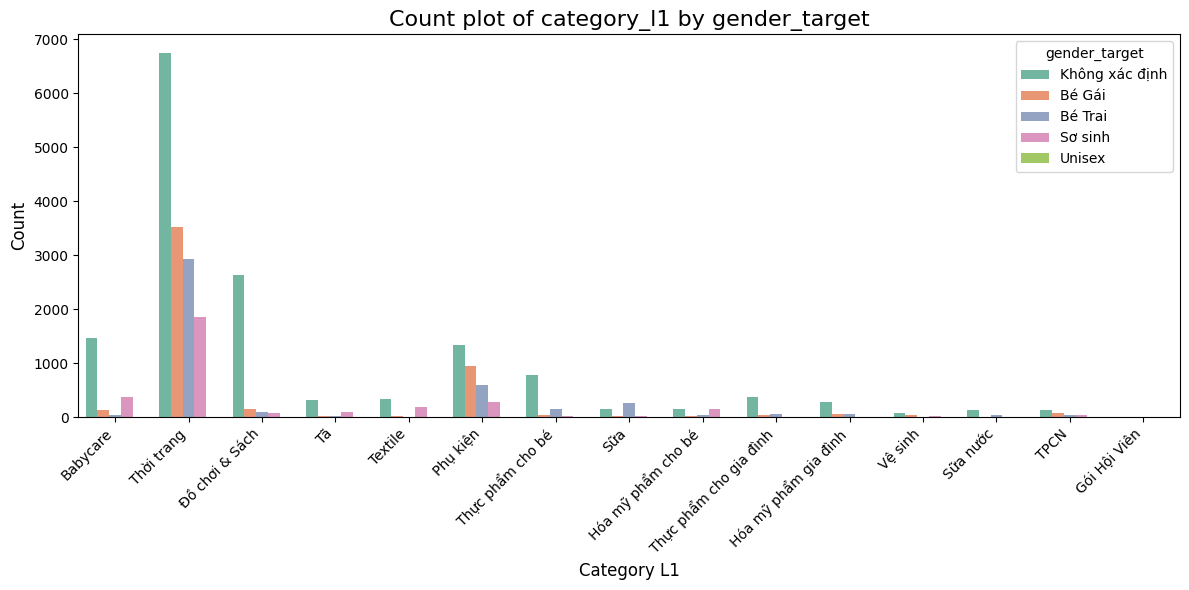

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Giả sử df_item là DataFrame Polars với cột 'category_l1' và 'gender_target'

# Chuyển df_item sang Pandas để dễ dàng sử dụng với seaborn
df_item_pd = df_item.to_pandas()

# Vẽ biểu đồ countplot giữa 'category_l1' và 'gender_target', với 'gender_target' là hue
plt.figure(figsize=(12, 6))
sns.countplot(x='category_l1', hue='gender_target', data=df_item_pd, palette="Set2")

# Thêm tiêu đề và nhãn
plt.title("Count plot of category_l1 by gender_target", fontsize=16)
plt.xlabel('Category L1', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Xoay nhãn trục x để dễ đọc
plt.xticks(rotation=45, ha='right')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


#### Biểu đồ sau khi biến đổi

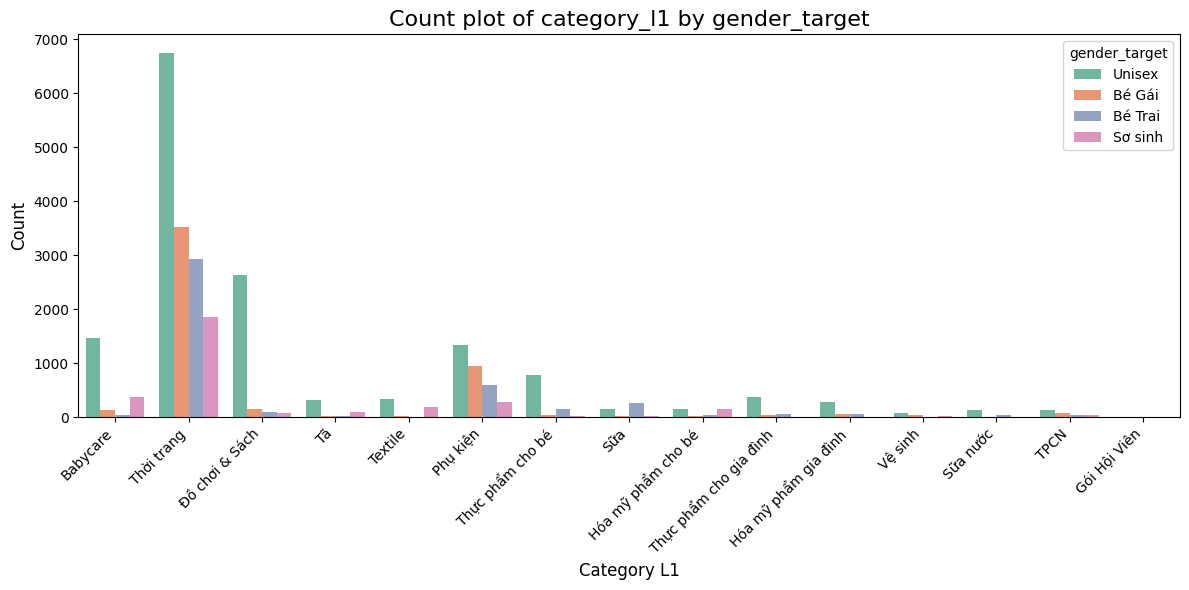

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Giả sử df_item là DataFrame Polars với cột 'category_l1' và 'gender_target'

# Chuyển df_item sang Pandas để dễ dàng sử dụng với seaborn
df_item_pd = df_item.to_pandas()

# Vẽ biểu đồ countplot giữa 'category_l1' và 'gender_target', với 'gender_target' là hue
plt.figure(figsize=(12, 6))
sns.countplot(x='category_l1', hue='gender_target', data=df_item_pd, palette="Set2")

# Thêm tiêu đề và nhãn
plt.title("Count plot of category_l1 by gender_target", fontsize=16)
plt.xlabel('Category L1', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Xoay nhãn trục x để dễ đọc
plt.xticks(rotation=45, ha='right')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()
